# 2: LLM Agents

In this demo we have a basic LangChain agent. The objective is to get familiar with the architecture, make changes, and see how they affect the agent's behavior. 


## Environment and ollama sanity checks

Make sure you are using the python binary in the virtual environment:

In [1]:
!which python

/Users/cesargmx/llm-workshop/llm-workshop/bin/python


Ensure Ollama and the llama3 models are installed and properly setup.

In [2]:
from langchain_ollama import ChatOllama

llm = ChatOllama(model="llama3.1", temperature=0.5)
response = llm.invoke("who wrote A Song of Ice and Fire?")
print(response.content)


A great question about a fantastic series!

The author who wrote the book series "A Song of Ice and Fire" is George R. R. Martin.

Martin is an American novelist, screenwriter, and television producer, best known for his epic fantasy series that was adapted into the hit HBO show "Game of Thrones". The books in the series are:

1. A Game of Thrones (1996)
2. A Clash of Kings (1999)
3. A Storm of Swords (2000)
4. A Feast for Crows (2005)
5. A Dance with Dragons (2011)

And, two more books are planned to complete the series: The Winds of Winter and A Dream of Spring.

Martin is known for his intricate world-building, complex characters, and unexpected plot twists, which have captivated readers worldwide.


## Part 1. Agents


The core idea of agents is to use a language model to choose a sequence of actions to take. These actions are defined as function or tool calls. 

### Chains vs Agents
In chains, a sequence of actions is hardcoded (in code). In agents, a language model is used as a reasoning engine to determine which actions to take (i.e. tools to run) and in which order.

[Agent](https://www.internalfb.com/intern/px/p/5TD8R)

<img src="Agent.png" width="800" height="400">


### Agent Actions - Tools

LLMs can benefit from using tools to overcome the limitations of their training data, such as outdated information and hallucinations. By providing LLMs with access to tools, they can answer questions within a controlled context that draws on existing knowledge bases and internal APIs. This allows LLMs to perform intermediate steps to gather relevant information and provide more accurate and up-to-date answers to questions. Additionally, tools can be used in combination to enhance the capabilities of LLMs. 

For example, a language model can be made to use a search tool to lookup quantitative information, perform analysis on the data, and then take actions based on the analysis. The first step in this example is to define the tools available to the LLM. 

In [3]:
import json 

tools = [
    {
        "type": "function",
        "function": {
            "name": "should_investor_buy_stock",
            "description":  "This tool gets the investor id, and a stock symbol as input. It gets the "
                            "investor profile and evaluates if it should buy stock from the provided symbol, "
                            "according to the stock performance, the investor protfolio, their goals and "
                            "risk profile. The tool returns a coefficient between (0, 1) representing how "
                            "beneficial is for the investor to buy.",
            "parameters": {
                "type": "object",
                "properties": {
                    "symbol": {
                        "type": "string",
                        "description": "The stock symbol, e.g. META."
                    },
                    "investor_id": {
                        "type": "number",
                        "description": "The ID of the investor."
                    }
                },
                "required": ["symbol", "investor_id"]
            }
        },
        "type": "function",
        "function": {
            "name": "should_investor_sell_stock",
            "description":  "This tool gets the investor id, and a stock symbol as input. It gets the "
                            "investor profile and evaluates if it should sell stock from the provided symbol, "
                            "according to the stock performance, the investor protfolio, their goals and "
                            "risk profile. The tool returns a coefficient between (0, 1) representing how "
                            "beneficial is for the investor to sell.",
            "parameters": {
                "type": "object",
                "properties": {
                    "symbol": {
                        "type": "string",
                        "description": "The stock symbol, e.g. META."
                    },
                    "investor_id": {
                        "type": "number",
                        "description": "The ID of the investor."
                    }
                },
                "required": ["symbol", "investor_id"]
            }
        },
    }
]

json.dumps(tools)

'[{"type": "function", "function": {"name": "should_investor_sell_stock", "description": "This tool gets the investor id, and a stock symbol as input. It gets the investor profile and evaluates if it should sell stock from the provided symbol, according to the stock performance, the investor protfolio, their goals and risk profile. The tool returns a coefficient between (0, 1) representing how beneficial is for the investor to sell.", "parameters": {"type": "object", "properties": {"symbol": {"type": "string", "description": "The stock symbol, e.g. META."}, "investor_id": {"type": "number", "description": "The ID of the investor."}}, "required": ["symbol", "investor_id"]}}}]'

Then we need to create a system prompt to give the LLM an instruction, let it be aware of the tools, and define a structured way to present the output. 

In [4]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

messages = [
    SystemMessagePromptTemplate.from_template(
        "You are a quant assistant that helps investors answer questions about stock symbols. "
        "Given the following functions, please respond with a JSON for a function call with its proper arguments that best answers the given prompt. "
        'Respond in the format [{{"name": function1_name, "parameters": dictionary of argument name and its value}},{{"name": function2_name, "parameters": dictionary of argument name and its value}},... ]. '
        "Do not use variables. NO other text MUST be included. \n{tools_available}"
        "Use the context bellow as extra information. "
        "Context: "
        "investor_id={investor_id}"
    ),
    HumanMessagePromptTemplate.from_template("{input}"),
]

prompt = ChatPromptTemplate.from_messages(messages)
prompt = prompt.partial(
    tools_available=json.dumps(tools).replace("{", "{{").replace("}", "}}"),
    investor_id=239487
)


In [5]:
from langchain_core.prompts import PromptTemplate 
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1", 
    temperature=0,
)

In [6]:
chain = prompt | llm | JsonOutputParser()

In [7]:
chain.invoke("Question: Should I sell microsoft stock?")

[{'name': 'should_investor_sell_stock',
  'parameters': {'symbol': 'MSFT', 'investor_id': 239487}}]

### Tool Calling

Note that this is not executing the actual tools, but the LLM now knows based on the user input, if it should use a tool to expand its context to answer the question. Let's address this. 

First thing to note is that langchain offers tool support. This will make it easier to define and execute the tools. 

In [8]:
import random
from langchain_core.tools import tool

@tool
def should_investor_buy_stock(symbol: str, investor_id: int) -> float:
    """This tool gets the investor id, and a stock symbol as input. It gets the
    investor profile and evaluates if it should buy stock from the provided symbol,
    according to the stock performance, the investor protfolio, their goals and
    risk profile. The tool returns a coefficient between (0, 1) representing how 
    beneficial is for the investor to buy.
    """
    return random.random()

@tool
def should_investor_sell_stock(symbol: str, investor_id: int) -> float:
    """This tool gets the investor id, and a stock symbol as input. It gets the
    investor profile and evaluates if it should sell stock from the provided symbol,
    according to the stock performance, the investor protfolio, their goals and
    risk profile. The tool returns a coefficient between (0, 1) representing how 
    beneficial is for the investor to sell.
    """
    return random.random()


You may have noticed that we added doc strings and a decorator to the function definition. The next cell shows the result of these changes:

In [9]:
print(should_investor_buy_stock.name)
print(should_investor_buy_stock.description)
print(should_investor_buy_stock.args)
print(type(should_investor_buy_stock))

should_investor_buy_stock
This tool gets the investor id, and a stock symbol as input. It gets the
    investor profile and evaluates if it should buy stock from the provided symbol,
    according to the stock performance, the investor protfolio, their goals and
    risk profile. The tool returns a coefficient between (0, 1) representing how 
    beneficial is for the investor to buy.
{'symbol': {'title': 'Symbol', 'type': 'string'}, 'investor_id': {'title': 'Investor Id', 'type': 'integer'}}
<class 'langchain_core.tools.structured.StructuredTool'>


And we use the `invoke` method to execute the tool:

In [10]:
should_investor_buy_stock.invoke(input={"symbol": "META", "investor_id": 123})

0.5994799336978958

Now we need to bind the tools to the LLM. 

In [11]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
).bind_tools([should_investor_buy_stock, should_investor_sell_stock])
llm.kwargs

{'tools': [{'type': 'function',
   'function': {'name': 'should_investor_buy_stock',
    'description': 'This tool gets the investor id, and a stock symbol as input. It gets the\n    investor profile and evaluates if it should buy stock from the provided symbol,\n    according to the stock performance, the investor protfolio, their goals and\n    risk profile. The tool returns a coefficient between (0, 1) representing how \n    beneficial is for the investor to buy.',
    'parameters': {'properties': {'symbol': {'type': 'string'},
      'investor_id': {'type': 'integer'}},
     'required': ['symbol', 'investor_id'],
     'type': 'object'}}},
  {'type': 'function',
   'function': {'name': 'should_investor_sell_stock',
    'description': 'This tool gets the investor id, and a stock symbol as input. It gets the\n    investor profile and evaluates if it should sell stock from the provided symbol,\n    according to the stock performance, the investor protfolio, their goals and\n    risk pro

In [12]:
result = llm.invoke("Question: Should I buy MSFT stock?")

In [13]:
result.tool_calls

[{'name': 'should_investor_buy_stock',
  'args': {'investor_id': 12345, 'symbol': 'MSFT'},
  'id': '848ecd6f-a3ed-46e4-acab-e44da931a067',
  'type': 'tool_call'}]

### E2E Flow

In [14]:
# Create this variable to make calling functions easier
tools_available = {
    'should_investor_buy_stock': should_investor_buy_stock,
    'should_investor_sell_stock': should_investor_sell_stock
}

In [15]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

# We get the query from a UI tool.
query = "Should I buy MSFT stock?"

# Pass it to the conversation log
messages = [HumanMessage(query)]

In [16]:
# Invoke the llm, and add the llm response to the conversation log
ai_msg = llm.invoke(messages)
messages.append(ai_msg)

In [18]:
ai_msg.tool_calls

[{'name': 'should_investor_buy_stock',
  'args': {'investor_id': 12345, 'symbol': 'MSFT'},
  'id': '9b7ae74f-f850-4363-8f05-b0a6eb1dfe36',
  'type': 'tool_call'}]

In [19]:
tool_call = ai_msg.tool_calls[0]
selected_tool = tools_available.get(tool_call['name'], None)
selected_tool

StructuredTool(name='should_investor_buy_stock', description='This tool gets the investor id, and a stock symbol as input. It gets the\n    investor profile and evaluates if it should buy stock from the provided symbol,\n    according to the stock performance, the investor protfolio, their goals and\n    risk profile. The tool returns a coefficient between (0, 1) representing how \n    beneficial is for the investor to buy.', args_schema=<class 'langchain_core.utils.pydantic.should_investor_buy_stock'>, func=<function should_investor_buy_stock at 0x105566820>)

In [20]:
for tool_call in ai_msg.tool_calls:
    selected_tool = tools_available.get(tool_call['name'], None)
    if selected_tool:
        tool_msg = selected_tool.invoke(tool_call)
        messages.append(tool_msg)

In [21]:
messages

[HumanMessage(content='Should I buy MSFT stock?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-07T18:02:50.075891Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'should_investor_buy_stock', 'arguments': {'investor_id': 12345, 'symbol': 'MSFT'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 1737243875, 'load_duration': 32849625, 'prompt_eval_count': 375, 'prompt_eval_duration': 585627000, 'eval_count': 31, 'eval_duration': 1117064000}, id='run-2f608da8-e059-435d-8b38-34c29317567c-0', tool_calls=[{'name': 'should_investor_buy_stock', 'args': {'investor_id': 12345, 'symbol': 'MSFT'}, 'id': '9b7ae74f-f850-4363-8f05-b0a6eb1dfe36', 'type': 'tool_call'}], usage_metadata={'input_tokens': 375, 'output_tokens': 31, 'total_tokens': 406}),
 ToolMessage(content='0.08656697426781146', name='should_investor_buy_stock', tool_call_id='9b7ae74f

In [22]:
# Finally, we invoke the model with the tool results
llm.invoke(messages)


AIMessage(content='Based on the tool call response, it appears that I have received a numerical value indicating a probability or score related to the question of whether you should buy MSFT stock.\n\nTherefore, my answer is:\n\nYes, based on the analysis, there is an approximately 8.66% chance that buying MSFT stock would be a good investment decision for you.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-07T18:05:48.210364Z', 'message': {'role': 'assistant', 'content': 'Based on the tool call response, it appears that I have received a numerical value indicating a probability or score related to the question of whether you should buy MSFT stock.\n\nTherefore, my answer is:\n\nYes, based on the analysis, there is an approximately 8.66% chance that buying MSFT stock would be a good investment decision for you.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 3226463333, 'load_duration': 32387541, 'prompt_eval_count': 98, 'prompt_eval_du

### Exercise: Can you wrap the E2E flow in a single class/function?

## Part 2: Graphs

The example we did in part 1 is very simple, it only has two tools. The real power from LLM agents comes from extending this basic flows to create graphs to answer queries and solve tasks. 

### Basic Chatbot Agent with Graphs

The first thing you do when you define a graph is define the `State` of the graph. The State consists of the schema of the graph as well as [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) which specify how to apply updates to the state. In our example `State` is a `TypedDict` with a single key: `messages`. The `messages` key is annotated with the [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) reducer function, which tells LangGraph to append new messages to the existing list, rather than overwriting it. State keys without an annotation will be overwritten by each update, storing the most recent value. Check out this [conceptual guide](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages) to learn more about state, reducers and other low-level concepts.

In [23]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

So now our graph knows two things:

1. Every node we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be appended to the current list, rather than directly overwritten. This is communicated via the prebuilt `add_messages` function in the Annotated syntax.

   
Next, add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.

In [24]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
)

# Notice how the chatbot node function takes the current State as input and returns a dictionary 
# containing an updated messages list under the key "messages". This is the basic pattern for all 
# LangGraph node functions.
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)

Next, add an entry point. This tells our graph where to start its work each time we run it. Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."

In [25]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.


In [26]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.


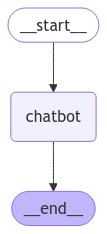

In [27]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


Now let's run the chatbot. 

In [28]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        # exit the chat loop at any time by typing "quit", "exit", or "q"
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What is the symbol ticker for Meta?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  Tell me about Meta


Assistant: Meta builds technologies that help people connect, find communities and grow businesses. The company's primary products include Facebook, Instagram, Threads and WhatsApp, in addition to other products and services.


User:  q


Goodbye!


### Chatbot with tools

We start with the same code as in the previous example: 

In [29]:
# tools from part 1
tools = [should_investor_buy_stock, should_investor_sell_stock]

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# We bind tools this time
llm = ChatOllama(
    model="llama3.1",
    temperature=0,
).bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)


Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

In [30]:
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Recall that **edges** route the control flow from one node to the next. Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.


In [31]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Starting point is the chatbot
graph_builder.add_edge(START, "chatbot")

# Because the conditional edge can return END, we don't need to explivitly set a finish point
graph = graph_builder.compile()

Let's visualize the graph we've built. 

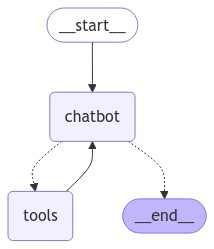

In [32]:
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What is the symbol ticker for Meta?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  Should investor 12345 buy META?


Assistant: 
Assistant: 0.9788641783839834
Assistant: Based on the tool call response, I would recommend that investor 12345 buy META.

The output value of 0.9788641783839834 is a probability score between 0 and 1, indicating the likelihood of a positive return on investment for META. A score above 0.5 suggests a high probability of a positive return, making it a good investment opportunity for investor 12345.


User:  I'm sad


Assistant: 
Assistant: 0.3650243174585278
Assistant: It seems like you're feeling a bit down. Would you like to talk about what's on your mind? Sometimes sharing what's bothering us can help lighten the mood. I'm here to listen!


You can use LangGraph for various applications such as:
* Complex task automation, i.e. run books
* Custom LLM-backed experiences, i.e. assistant that helps create incident reports from SEV chats.


## Resources

There are pre-buillt components that make using LangGraph easier. Check them out in the official [API reference](https://langchain-ai.github.io/langgraph/reference/prebuilt/)